# Solution 4

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Raul Renteria
* rrenteria@uchicago.edu

# 1 HBS Case: The Information Content of the Yield Curve

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

In [2]:
def plot_dataframe(data, title=None, x_label=None, y_label=None, legend=True, legend_labels=None, **kwargs):
    """
    Plot time series data from a DataFrame or Series.

    Parameters:
    - data: pandas DataFrame or Series
        The data to be plotted. If a Series is passed, it will be converted to a DataFrame.
    - title: str, optional
        Title of the plot.
    - x_label: str, optional
        Label for the x-axis.
    - y_label: str, optional
        Label for the y-axis.
    - legend: bool, optional
        Whether to display the legend (default is True).
    - legend_labels: list of str, optional
        List of custom labels for the legend. Should have the same length as the number of columns in the DataFrame.
    - **kwargs: Additional keyword arguments for the plot function.

    Returns:
    - None
    """
    if isinstance(data, pd.Series):
        data = pd.DataFrame({data.name if data.name is not None else 'values': data})

    if data.empty:
        print("Data is empty. Cannot plot.")
        return

    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.title(title or "Time Series Plot")
    plt.xlabel(x_label or "Time")
    plt.ylabel(y_label or "Values")

    for col in data.columns:
        label = legend_labels[data.columns.get_loc(col)] if legend_labels else col
        plt.plot(data.index, data[col], label=label, **kwargs)

    if legend:
        plt.legend()

    plt.show()

## 1.1

The Term Spread
* What is the term spread? 
* What is the preferred measure of the term spread in the case?
* What evidence is cited for the term spread's power in predicting recessions?
* Which is more important, the level of the term spread, its month-over-month change, or the level of short rates?

Using the file `yields.xlsx`, calculate the term spread at the end of the sample.
* What does this term spread suggest about economic growth, according to the evidence of Estrella?


- **Term Spread:** is the difference between the long-term and short-term interest rates
- The preferred measure, in the case latest, is the 10yr - 3mo. Though using 10yr - 1yr is fine, just as we are doing in this assignment
- blah blah
- The level of the term spread is more important

In [3]:
dir = '../../finm-fixedincome-2024/data/'
file = 'yields.xlsx'
yields = pd.read_excel(dir + file, sheet_name='yields', index_col=0)

In [4]:
term_spread = yields[10] - yields[1]
term_spread

caldt
1961-06-14    0.882912
1961-06-15    0.930051
1961-06-16    0.933333
1961-06-19    0.965321
1961-06-20    0.934087
                ...   
2023-11-24   -0.824011
2023-11-27   -0.869871
2023-11-28   -0.949225
2023-11-29   -0.900711
2023-11-30   -0.854395
Length: 15598, dtype: float64

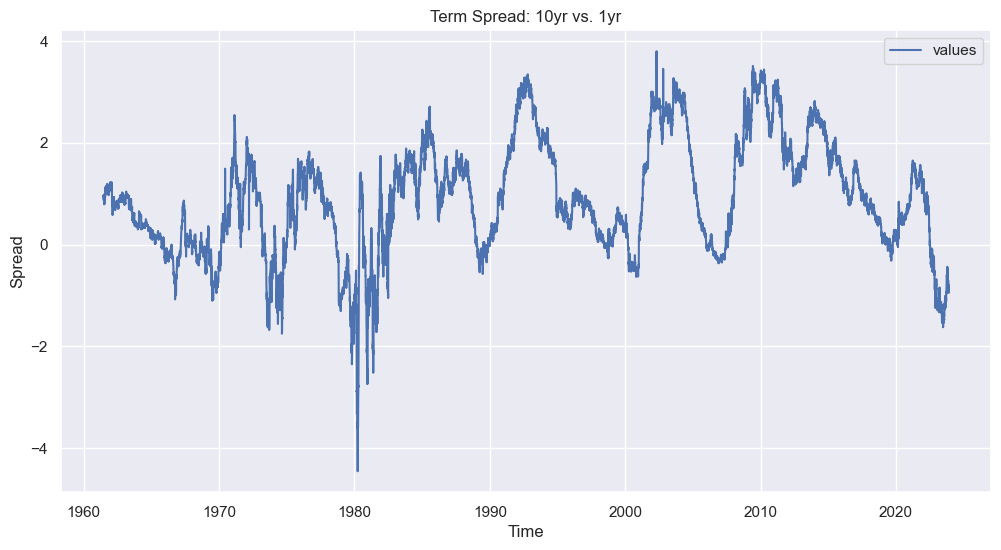

In [5]:
plot_dataframe(term_spread, title='Term Spread: 10yr vs. 1yr', y_label='Spread')

According to Estrella, the term spread has a positive relationship with US real GDP. Estrella also mentions that the "level of the term spread is what matter, not whether the slope is positive or negative." In our case the end of the series of our data is negative, thus implying a recession.

## 1.2
Term premia
* What is the term premium? Why is it impossible to get a direct measure of it?
* Explain equations (1) and (2). Why does Sacks think this concept of the term spread complicates the relationship found by Estrella?

- **Term premium** is the compensation investors require for bearing the risk that interest rates may change over the life of the bond. It's impossible to get a direct measure because no one can accurately predict where interest rates will go, thus unable to calculate the right amount of premium
- Equation (1) and (2) model the relationship of the rates as an expected average of the rates or expected change in the range plus some term premium. This complicated things, because Sacks argued that if the premium tightened, the yield curve would flatten and that would mean faster growth. Which was directly opposite to what the FED had said

## 1.3

Though this case touches on monetary policy, that is not our focus. Rather, our focus is the degree to which the current shape of the yield curve is predictive of future short-term interest rates.

Suppose the term premium is zero. 
* What does a downward-sloping yield curve predict about future short-term rates? 
* In this case, is it risky to hold long-term bonds or short-term bonds? Is this risk compensated?

Suppose the term premium increases 5 percentage points.
* What would change about your previous answer?

**Zero Term premium**
- According to sack, in the case where the yield curve is downward-sloping we would expect GDP growth to pick up. Thus short-term rates would go down
- A term premium of 0 implies there is no risk in holding these long-term bonds. There's definitely still interest rate risk, though investors don't expect to get compensated for

**Increase in the term premium**


***

# 2 Calculating Forwards

Use the treasury issues in `'../data/select_maturities_2023-08-31.xlsx`. 

The selected treasuries are at nearly six-month intervals. Approximate that they mature at perfect 6-month intervals. 

In [6]:
def calc_cashflows(quote_data):
    cash_flows = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'date'], quote_data.loc[i,'maturity date'])

        if coupon_dates is not None:
            cash_flows.loc[i,coupon_dates] =  quote_data.loc[i,'cpn rate'] / 2

        cash_flows.loc[i,quote_data.loc[i,'maturity date']] += 100

    cash_flows = cash_flows.fillna(0).sort_index(axis=1)
    cash_flows.drop(columns=cash_flows.columns[(cash_flows==0).all()], inplace=True)
        
    return cash_flows

def get_coupon_dates(quote_date,maturity_date):

    if isinstance(quote_date,str):
        quote_date = datetime.datetime.strptime(quote_date,'%Y-%m-%d')
        
    if isinstance(maturity_date,str):
        maturity_date = datetime.datetime.strptime(maturity_date,'%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

In [7]:
file = 'select_maturities_2023-08-31.xlsx'
treasuries = pd.read_excel(dir + file)
treasuries.set_index('kytreasno', inplace=True)
treasuries

,date,issue date,maturity date,ttm,bid,ask,accrint,ytm,duration,outstanding,cpn rate,instrument
kytreasno,,,,,,,,,,,,
208097,2023-08-31,2023-08-31,2024-02-29,0.498289,97.333194,97.338250,0.000000,0.000148,182.000000,66723,0.000,4
207928,2023-08-31,2022-08-31,2024-08-31,1.002053,97.929688,97.945312,0.000000,0.000145,363.026814,49726,3.250,2
208013,2023-08-31,2023-02-28,2025-02-28,1.497604,99.281250,99.296875,0.000000,0.000139,534.703977,51530,4.625,2
208101,2023-08-31,2023-08-31,2025-08-31,2.001369,100.234375,100.269531,0.000000,0.000132,704.689328,49666,5.000,2
207676,2023-08-31,2021-02-28,2026-02-28,2.496920,90.265625,90.296875,0.000000,0.000126,907.180690,74214,0.500,2
207759,2023-08-31,2021-08-31,2026-08-31,3.000684,89.500000,89.523438,0.000000,0.000123,1085.093032,68664,0.750,2
207845,2023-08-31,2022-02-28,2027-02-28,3.496235,91.695312,91.718750,0.000000,0.000121,1240.082921,62080,1.875,2
207930,2023-08-31,2022-08-31,2027-08-31,4.000000,95.390625,95.414062,0.000000,0.000119,1382.439796,50858,3.125,2
208015,2023-08-31,2023-02-28,2028-02-29,4.498289,98.710938,98.718750,0.000000,0.000117,1518.888512,52769,4.000,2


## 2.1 
Bootstrap the discount factor. 

Plot the answer in terms of discount factors and discount rates.

#### Simplification 
Though the time-to-maturity (ttm) is not spaced exactly at 6 months, for the purposes of this problem, you are welcome to approximate that they are spaced at exact 6-month intervals.

In [8]:
cash_flows = calc_cashflows(treasuries)
cash_flows_monthly = cash_flows.resample('m',axis=1).sum()
cash_flows_monthly.drop(columns=cash_flows_monthly.columns[(cash_flows_monthly==0).all()], inplace=True)
cash_flows_monthly = cash_flows_monthly.fillna(0).sort_index(axis=1)
cash_flows_monthly

,2024-02-29,2024-08-31,2025-02-28,2025-08-31,2026-02-28,2026-08-31,2027-02-28,2027-08-31,2028-02-29,2028-08-31,2029-02-28,2029-08-31,2030-02-28,2030-08-31,2031-02-28,2031-08-31,2032-02-29,2032-08-31,2033-02-28,2033-08-31
kytreasno,,,,,,,,,,,,,,,,,,,,
208097,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207928,1.6250,101.6250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208013,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208101,2.5000,2.5000,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207676,0.2500,0.2500,0.2500,0.2500,100.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207759,0.3750,0.3750,0.3750,0.3750,0.3750,100.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207845,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207930,1.5625,1.5625,1.5625,1.5625,1.5625,1.5625,1.5625,101.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208015,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,102.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


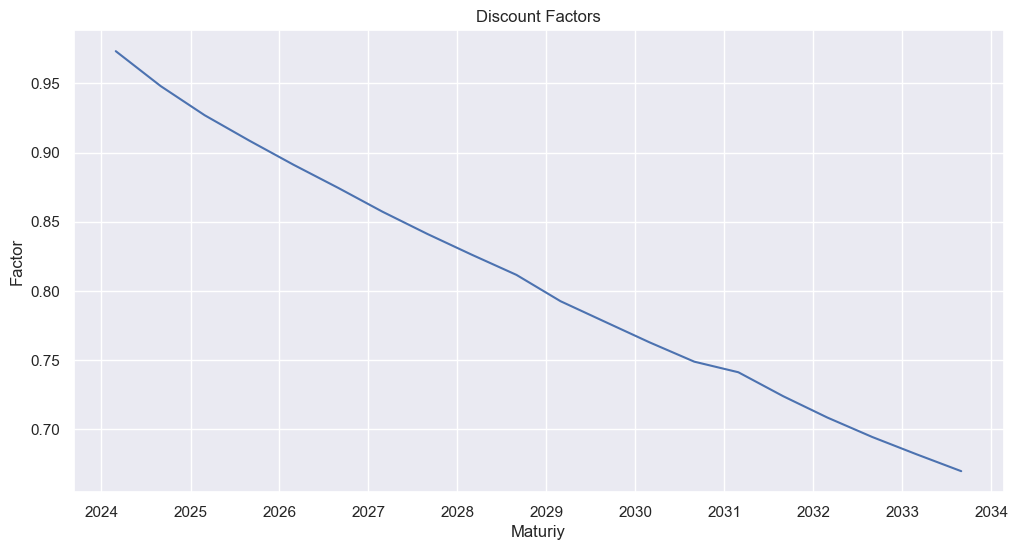

In [9]:
prices = 0.5 * (treasuries['bid'] + treasuries['ask']) + treasuries['accrint']
discounts = np.linalg.lstsq(cash_flows_monthly, prices, rcond=None)[0]
discounts_df = pd.DataFrame(discounts, index=cash_flows_monthly.columns)
plot_dataframe(discounts_df, title='Discount Factors', y_label='Factor', x_label='Maturiy', legend=False)

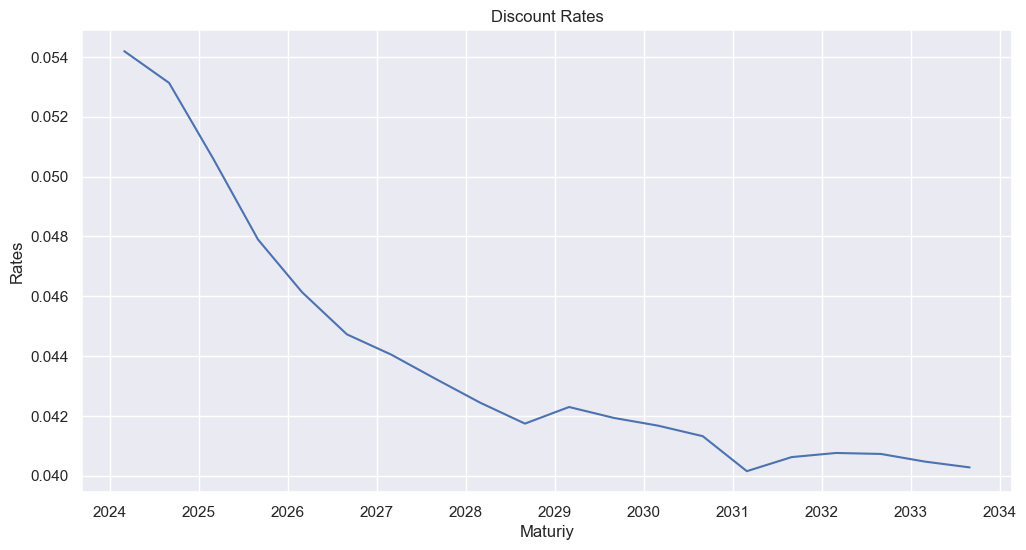

In [10]:
intrate = - np.log(discounts) / treasuries['ttm']
intrate.index = cash_flows_monthly.columns
plot_dataframe(intrate, 'Discount Rates', y_label='Rates', x_label='Maturiy', legend=False)

In [11]:
discounts

array([0.97335722, 0.9481505 , 0.92701846, 0.90859159, 0.89119173,
       0.874407  , 0.85725805, 0.8411927 , 0.82620107, 0.81156245,
       0.79252541, 0.77751606, 0.76280508, 0.74880364, 0.7411466 ,
       0.72382906, 0.70834118, 0.69430166, 0.68185209, 0.66960702])

***

## 2.2
Calculate and plot the forward discount factors from $T$ to $T+0.5$, ranging $T$ from 0.5 through 9.5.

In [12]:
forward_discount_factors = discounts_df / discounts_df.shift()
forward_discount_factors.index = np.arange(0.5, (len(discounts) + 1) * 0.5, 0.5)
forward_discount_factors.iloc[0] = discounts[0]
forward_discount_factors

,0
0.5,0.973357
1.0,0.974103
1.5,0.977712
2.0,0.980122
2.5,0.980850
3.0,0.981166
3.5,0.980388
4.0,0.981260
4.5,0.982178
5.0,0.982282


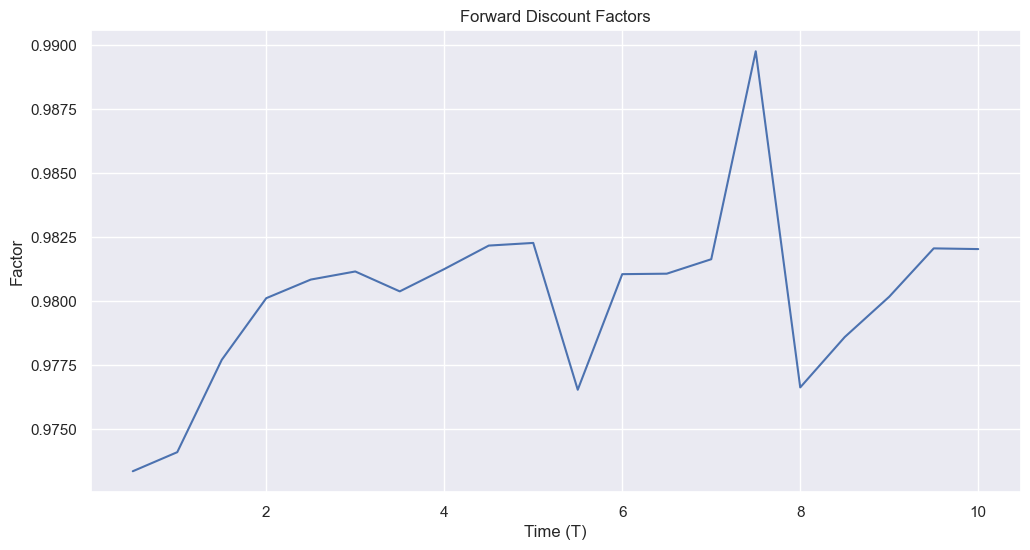

In [13]:
plot_dataframe(forward_discount_factors,'Forward Discount Factors', y_label='Factor', x_label='Time (T)', legend=False)

## 2.3
Use the forward discount factors to calculate the `semiannually` compounded forward **rates**.

Plot the curve.

Also report the forward-rate values from 

* $T_1=0.5$ to $T_2=1$.
* $T_1=9.5$ to $T_2=10$.

In [14]:
forward_rates = -np.log(forward_discount_factors) / 0.5

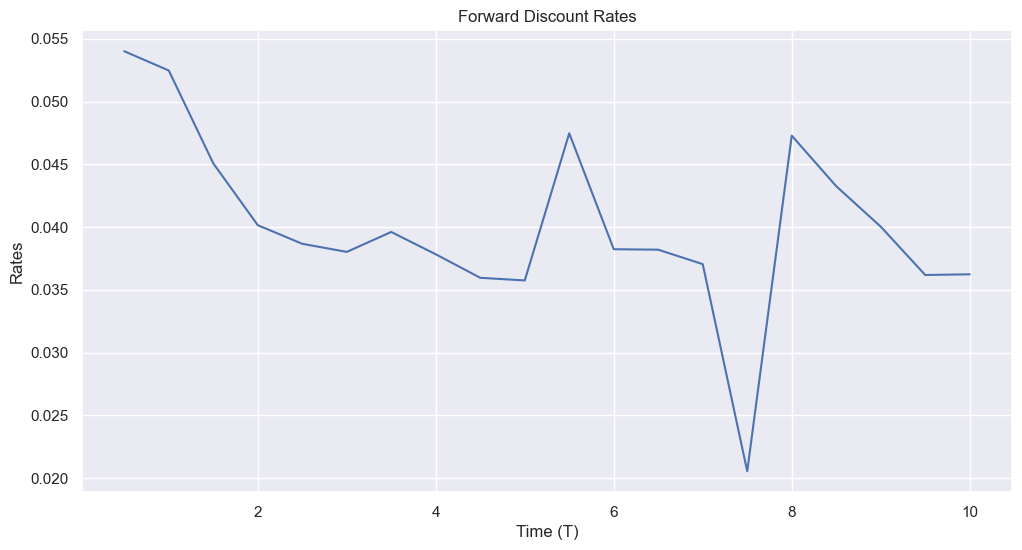

In [15]:
plot_dataframe(forward_rates,'Forward Discount Rates', y_label='Rates', x_label='Time (T)', legend=False)

In [16]:
print(f'Forward rate from 0.5 to 1 = {forward_rates.loc[1][0]:.2%}')
print(f'Forward rate from 9.5 to 10 = {forward_rates.loc[10][0]:.2%}')

Forward rate from 0.5 to 1 = 5.25%
Forward rate from 9.5 to 10 = 3.62%


## 2.4
Explain how an FRA between $T_1$ and $T_2$ would function. 

An FRA would have a notional amount, a reference rate, and a FRA rate. The difference between T2 and T1 would be the period amount. So you calculate the payment with these parameters. You never exchange the notional, just the calculated payment. If the amount is positive the FRA seller pays this amount to the buyer, and vice-versa